
## Introduction
In this project we are using random forests to predict the digit based on the input pixels from each pixel using MNIST dataset. This dataset is one of the largest labelled handwritten dataset, based on the the input pixels we shall classify which number would be the output for certain pixels.

To achieve our predictions we shall build random forests based upon decision trees in which we will use multiple decision trees. We shall send our data into different decision trees parallely and aggregate their output to determine the output of our random forest. In this algorithm our data is being split randomly and processed parallely in multiple decision trees to get our output faster, we also would reduce the depth of the tree so it would process faster. 

Decision tree divides the problem into multiple questions and considers each question as a node where it determines the answer by dividing into two parts yes and no, then it further devides those answers into sub branches and calculates the probability at each split till it reaches the end and then adds all those probabilities to get a certain output.

Random forests use multiple decision trees where we will randomize the data and send it to decision trees.In this we randomize the data and then split it and sent it to multiple decision trees, and combine their output.

Here we shall see how the random forest works by building it from scratch by explaining each and every step we use clearly.


In [1]:
# import the necessary libraries
import random
import numpy as np
import pandas as pd
from math import sqrt
from random import randrange


In [2]:
#reading the dataset
mnist_train = pd.read_csv("/Users/sarankaja/downloads/MNIST-data/mnist_train.csv")
mnist_test=pd.read_csv("/Users/sarankaja/downloads/MNIST-data/mnist_test.csv")

In [3]:
mnist_train.head()

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# renaming the column name of predictor
mnist_train=mnist_train.rename ({'5':'label'},axis=1)
mnist_test=mnist_test.rename ({'7':'label'},axis=1)


In [5]:
y=pd.DataFrame(mnist_train['label'])

In [6]:
type(y)

pandas.core.frame.DataFrame

In [7]:
mnist_train1=mnist_train.drop('label',axis=1)
mnist_test1=mnist_test.drop('label',axis=1)

In [8]:
type(mnist_train1)

pandas.core.frame.DataFrame

In [9]:
mnist_test1.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
#converting the dataframe into a list
dataset=[]
testset=[]
testy=[]

for i in range(len(mnist_train)):
    
        dataset.append(list(mnist_train.loc[i]))
for i in range(len(mnist_test)):
        testset.append(list(mnist_test.loc[i]))

Here we are writing all the functions required to build the random forest algorith step by step

cross validation split- here we divide the data into differnt partitions based on the size of the folds and run the classifier multiple times and each time we choose a differnt validation set and training set and then we average their results. for example we took folds to be 5, here we are partitioning the data into 5 parts in which i have 5 test and train pairs, i use differnt combination each time to classify and take the average of thier resluts.

Test_split- here we will split the dataset based on a certain attribute value for example if a value is greater than one we will take it into left list or else into right list and make lists of both.

gini index- it determines how true the data is in each split and the chance that some value is misclassified.it is used to find the best split, if the value is close to zero it is classified as a best split, the closer the value to zero the better the split. It calculates the probability at each split,these values are then used to create the best split.
                            
                        1 – ( P(value1)^2 + P(value2)^2 + … + P(valueN)^2)
                        
Then using the gini index and features we shall determine the best split and use those probabilities to find the best split and then we shall divide them further into child nodes. 

we are building the decision tree based on parementers such as train,maximum depth,minimum size and features by selecting the data randomly and we are taking the help of bagging algorithm to determine the final output in which we take the data randomly from the actual datset we use this in order for the decision tree to make differnt splits every time else it would make the same splits everytime then we feed that into our decision trees and use the output of all the trees to predict the output.We shall then determine the acuuracy by taking the average of all our folds which would give us our final output.


In [21]:
# Splitting the data into n folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_l = list(dataset)
    fold_len = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_len:
            index = randrange(len(dataset_l))
            fold.append(dataset_l.pop(index))
        dataset_split.append(fold)
    return dataset_split


# We are splitting the dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

# Calculating the Gini index
def gini_index(groups, classes):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini
 
# Selecting the best split point based on the gini index and features
def get_split(dataset, n_features):
    class_values = list(set(row[-1] for row in dataset))
    #b_index-index of best column,b_value-best column cut off value,b_group-best group, b_score-gini index
    b_index, b_value, b_groups, b_score = None, None, None, 999
    features = list()
    while len(features) < n_features:
        index = randrange(len(dataset[0])-1)
        if index not in features:
            features.append(index)
    for index in features:
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}
 

def to_terminal(group):
    outcomes = [row[0] for row in group]
    return max(set(outcomes), key=outcomes.count)
 
# Create child splits for a node
def split(node, max_depth, min_size, n_features, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, n_features)
        split(node['left'], max_depth, min_size, n_features, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right, n_features)
        split(node['right'], max_depth, min_size, n_features, depth+1)
 
# Building a decision tree based on parameters such has train, maximum depth, minimum size and features
def build_tree(train, max_depth, min_size, n_features):
    root = get_split(train, n_features)
    split(root, max_depth, min_size, n_features, 1)
    return root
 
# Making a prediction with the help of decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']
 
# Create a random subsample from the dataset with replacement
def subsample(dataset, ratio):
    sample = list()
    n_sample = round(len(dataset) * ratio)
    while len(sample) < n_sample:
        index = randrange(len(dataset))
        sample.append(dataset[index])
    return sample
 
# Make a prediction with a list of bagged trees
def bagging_predict(trees, row):
    predictions = [predict(tree, row) for tree in trees]
    return max(set(predictions), key=predictions.count)
 
# Random Forest Algorithm
def random_forest(train, test, max_depth, min_size, sample_size, n_trees, n_features):
    trees = list()
    for i in range(n_trees):
        sample = subsample(train, sample_size)
        tree = build_tree(sample, max_depth, min_size, n_features)
        trees.append(tree)
    predictions = [bagging_predict(trees, row) for row in test]
    return(predictions)
 

# Calculating the accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0
 
# Evaluating the algorithm using a cross validation split
def evaluate_algorithm(dataset,testset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = testset
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[0] for row in fold]
       
        #print(actual)
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores


In [18]:
# evaluate algorithm
n_folds = 5
max_depth = 10
min_size = 1
sample_size = 1.0
#y=testy

n_features = int(sqrt(len(dataset[0])-1))
for n_trees in [1,10,50]:
    scores = evaluate_algorithm(dataset,testset, random_forest, n_folds, max_depth, min_size, sample_size, n_trees, n_features)
    print('Trees: %d' % n_trees)
    print('Scores: %s' % scores)
    print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Trees: 1
Scores: [10.5, 11.5, 8.0, 10.0, 9.0]
Mean Accuracy: 9.800%
Trees: 10
Scores: [11.5, 10.5, 7.000000000000001, 10.5, 9.5]
Mean Accuracy: 9.800%
Trees: 50
Scores: [9.5, 10.5, 12.0, 9.5, 7.5]
Mean Accuracy: 9.800%


## Second method

Here we are using pre existing libraries for decision tree, then we are running multiple trees taking the most repeated value from each array and plot the confusion matrix.

In [69]:
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

In [65]:
x_train=mnist_train.loc[:, mnist_train.columns != 'label']
y_train=mnist_train['label']
x_test=mnist_test.loc[:, mnist_test.columns != 'label']
y_test=mnist_test['label']

[2 1 0 4 1 4 0 6 9 0 6 9 0 1 5 9 7 9 4 9 6 6 5 4 0 7 4 0 1 3]
0.873987398739874


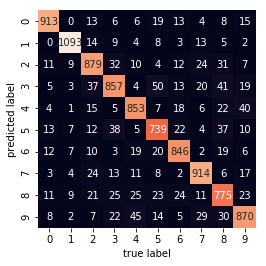

In [90]:
dc = DecisionTreeClassifier()
dc = dc.fit(x_train, y_train)
y_pred = dc.predict(x_test)
print(y_pred[0:30])

print(metrics.accuracy_score(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Confusion matrix of logistic regression:
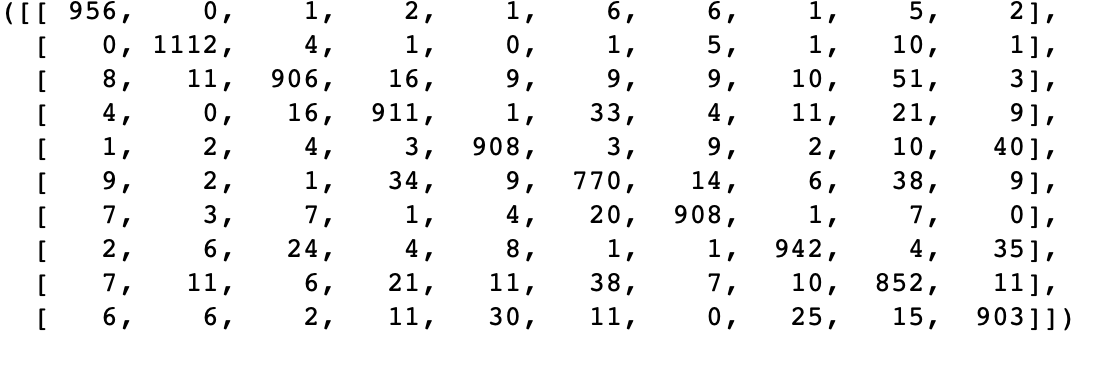

[array([6, 9, 7, ..., 6, 1, 7])]

 0.8611666666666666
[array([6, 9, 7, ..., 6, 1, 7]), array([6, 2, 1, ..., 7, 6, 0])]

 0.8600555555555556
[array([6, 9, 7, ..., 6, 1, 7]), array([6, 2, 1, ..., 7, 6, 0]), array([7, 1, 7, ..., 1, 2, 4])]

 0.8650555555555556


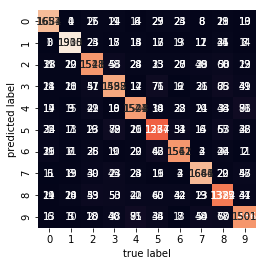

In [93]:
n_tree=[1,20,500]
pred_n_tree=[]
for trees in (n_tree):
    for i in range(1):
        sx=mnist_train.sample(frac=1)
        trainSet=[]
        testSet=[]
        for i in range(len(sx)):
            if(i< int(len(sx)*0.7)):
                trainSet.append(list(sx.iloc[i]))
            else:
                testSet.append(list(sx.iloc[i]))

        #separate label and pixel
        train_label=[]
        train_pixel=[]
        test_label=[]
        test_pixel=[]
        for i in range(len(trainSet)):
            train_label.append(trainSet[i][0])
            train_pixel.append(trainSet[i][1:])

        for i in range(len(testSet)):
            test_label.append(testSet[i][0])
            test_pixel.append(testSet[i][1:])

        dc = DecisionTreeClassifier()
        dc = dc.fit(train_pixel, train_label)
        y_pred = dc.predict(test_pixel)
        pred_n_tree.append(y_pred)
        print(pred_n_tree[0:30])

    print("\n",metrics.accuracy_score(test_label, y_pred))
    mat = confusion_matrix(test_label, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

## Conclusion
We ran the random forest algorithm successfully for 1,10 and 50 trees in the above code we can see the average accuracy for all the trees to be same but we can clearly see that the accuracy of each fold is varying. I ran the same algorithm for 500 trees which took 14 hours and gave an accuracy of 98.8% accuracy which was better compared to rest of the trees which clearly shows us that with increase in the number of trees the accuracy is increasing.Comparing to our logistic regression model random forest seems to be better as logistic regression gave us an accuracy of 91.6% which was less comapred to the accuracy we got from random forest.

When we compare both the methods it is better to use the second method as it is running a lot faster compared to implementing both decision tree and random forests from scratch.I think the first model is overfitting the data due to which the accuracy is much higher. comparing the second model with logistic regression the accuracies seem to be closer for both random forest and logistic regression.The model for 500 trees seem to be 86.5% which is less than that that of logistic regression 91.6% and the accuracy also increased with the increase in the number of trees. 

## References:
    http://people.csail.mit.edu/dsontag/courses/ml13/slides/lecture13.pdf
    Brownlee, J. (2019, August 13). How to Implement Random Forest From Scratch in Python. Retrieved from https://machinelearningmastery.com/implement-random-forest-scratch-python/.
    Singh, A. (2019, May 6). Building a Random Forest from Scratch & Understanding Real-World Data Products (ML for Programmers – Part 3). Retrieved from https://www.analyticsvidhya.com/blog/2018/12/building-a-random-forest-from-scratch-understanding-real-world-data-products-ml-for-programmers-part-3/.
    Silipo, R. (2019, July 23). From a Single Decision Tree to a Random Forest. Retrieved from https://www.dataversity.net/from-a-single-decision-tree-to-a-random-forest/.